In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
META_CSV = "HAM10000-dataset/metadata.csv"
df = pd.read_csv(META_CSV)
diagnosis_conversion = pd.read_json('HAM10000-dataset/diagnosis_conversion.json', typ='series')
df['diagnosis'] = df['diagnosis_2'].map(diagnosis_conversion)
df.rename(columns=({"isic_id": "image_id"}), inplace=True)

In [3]:
# Add full image path for each row
IMG_DIR = "HAM10000-dataset/images/"
df["filepath"] = df["image_id"].apply(lambda x: IMG_DIR + f"{x}.jpg")

In [4]:
print("Class distribution:")
print(df["diagnosis"].value_counts())

Class distribution:
diagnosis
nv       7737
bkl      1338
mel      1305
bcc       622
akiec     378
vasc      180
df        160
Name: count, dtype: int64


In [5]:
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
df["label"] = df["diagnosis"].map(label_map)

In [6]:
df = df[["image_id", "lesion_id", "diagnosis", "filepath", "label"]]

In [7]:
df.head()

,image_id,lesion_id,diagnosis,filepath,label
0,ISIC_0024306,IL_7252831,nv,HAM10000-dataset/images/ISIC_0024306.jpg,5
1,ISIC_0024307,IL_6125741,nv,HAM10000-dataset/images/ISIC_0024307.jpg,5
2,ISIC_0024308,IL_3692653,nv,HAM10000-dataset/images/ISIC_0024308.jpg,5
3,ISIC_0024309,IL_0959663,nv,HAM10000-dataset/images/ISIC_0024309.jpg,5
4,ISIC_0024310,IL_8194852,mel,HAM10000-dataset/images/ISIC_0024310.jpg,4


In [8]:
from sklearn.model_selection import GroupShuffleSplit

# Groups = lesion_id (fall back to image_id if any missing)
groups_all = df["lesion_id"].astype(str)
groups_all = groups_all.mask(groups_all.isna() | (groups_all == ""), df["image_id"].astype(str))

gss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=42)
trainval_idx, test_idx = next(gss.split(df, df["label"], groups_all))

trainval_df = df.iloc[trainval_idx].reset_index(drop=True)
test_df     = df.iloc[test_idx].reset_index(drop=True)

# sanity checks: no leakage
assert set(trainval_df["lesion_id"]).isdisjoint(set(test_df["lesion_id"]))
print("train+val:", len(trainval_df), " | test:", len(test_df))


train+val: 9348  | test: 2372


In [9]:
from sklearn.model_selection import GroupKFold

groups_tv = trainval_df["lesion_id"].astype(str)
groups_tv = groups_tv.mask(groups_tv.isna() | (groups_tv == ""), trainval_df["image_id"].astype(str))

gkf = GroupKFold(n_splits=5)
tr_idx, va_idx = next(gkf.split(trainval_df, trainval_df["label"], groups_tv))

train_df = trainval_df.iloc[tr_idx].reset_index(drop=True)
val_df   = trainval_df.iloc[va_idx].reset_index(drop=True)

# sanity checks: no overlap
assert set(train_df["lesion_id"]).isdisjoint(set(val_df["lesion_id"]))
print("train:", len(train_df), " | val:", len(val_df), " | test:", len(test_df))


train: 7478  | val: 1870  | test: 2372


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

NUM_CLASSES = 7
classes = np.arange(NUM_CLASSES)

cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
class_weights = {int(c): float(w) for c, w in zip(classes, cw)}
class_weights


{0: 4.378220140515222,
 1: 2.7747680890538033,
 2: 1.2523865349187742,
 3: 9.800786369593709,
 4: 1.2153421095400618,
 5: 0.2174406094617778,
 6: 11.245112781954887}

In [11]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 7

def decode_and_resize(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.convert_image_dtype(x, tf.float32)    # [0,1]
    # (Optional) center-crop to square first; if you want that, replace with the cropped version we discussed.
    x = tf.image.resize(x, (IMG_SIZE, IMG_SIZE))
    return x

def map_train(path, y):
    x = decode_and_resize(path)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.1)
    x = tf.image.random_contrast(x, 0.9, 1.1)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def map_eval(path, y):
    x = decode_and_resize(path)
    return x, tf.one_hot(y, depth=NUM_CLASSES)

def make_ds(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=42, reshuffle_each_iteration=True)
        ds = ds.map(map_train, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(map_eval,  num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df["filepath"].values, train_df["label"].values, training=True)
val_ds   = make_ds(val_df["filepath"].values,   val_df["label"].values,   training=False)
test_ds  = make_ds(test_df["filepath"].values,  test_df["label"].values,  training=False)


2025-11-08 00:36:38.473849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-08 00:36:38.486581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-08 00:36:38.490650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1762562200.709998    5258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762562200.721618    5258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

In [12]:
def plot_AUC(history):
    plt.figure()
    plt.plot(history.history["auc"], label="train auc")
    plt.plot(history.history["val_auc"], label="val auc")
    plt.legend(); plt.title("AUC"); plt.xlabel("epoch"); plt.ylabel("auc"); plt.show()

In [13]:
from sklearn.metrics import classification_report

target_names=["akiec","bcc","bkl","df","mel","nv","vasc"]

def classification_report_display(y_true, y_pred):
    print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))

In [14]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_display(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))

In [15]:
import tensorflow as tf
tf.keras.backend.clear_session()

IMG_SIZE = 256
NUM_CLASSES = 7

model_base = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

model_base.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_base = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

In [16]:
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


I0000 00:00:1762562203.415888    5307 service.cc:146] XLA service 0x747470016fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762562203.415965    5307 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9


  5/234 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - auc: 0.3368 - loss: 1.7254

I0000 00:00:1762562210.527120    5307 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


234/234 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - auc: 0.5402 - loss: 1.9779 - val_auc: 0.7286 - val_loss: 1.5751 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.6676 - loss: 1.8996 - val_auc: 0.7582 - val_loss: 1.3602 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - auc: 0.6915 - loss: 1.7691 - val_auc: 0.7413 - val_loss: 1.6087 - learning_rate: 0.0010
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.6896 - loss: 1.8080
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003333333491658171.
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - auc: 0.6896 - loss: 1.8081 - val_auc: 0.7677 - val_loss: 1.6107 - learning_rate: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - auc: 0.7270 - loss: 1.7978 - val_auc: 0.7854 - val_loss: 1.5437 - learning_rate: 3.3333e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.7491 - loss: 1.6368
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000111

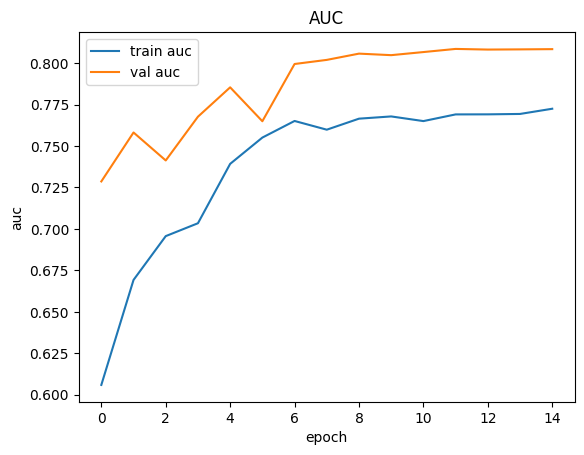

In [17]:
plot_AUC(history_base)

In [18]:
y_true = test_df["label"].values
probs  = model_base.predict(test_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.07      0.12      0.09        67
         bcc       0.16      0.62      0.25       113
         bkl       0.20      0.27      0.23       278
          df       0.02      0.11      0.04        19
         mel       0.29      0.49      0.36       245
          nv       0.96      0.49      0.65      1586
        vasc       0.18      0.31      0.23        64

    accuracy                           0.45      2372
   macro avg       0.27      0.34      0.26      2372
weighted avg       0.71      0.45      0.52      2372

[[  8  24   6  17   3   4   5]
 [ 12  70   8  13   2   1   7]
 [ 18 102  76  30  31  12   9]
 [  0  10   3   2   0   2   2]
 [ 19  31  57   2 120  14   2]
 [ 59 180 229  17 259 776  66]
 [  5  20   5  11   1   2  20]]


In [19]:
import tensorflow as tf

IMG_SIZE = 256
NUM_CLASSES = 7

base_B0 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_B0.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_B0(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model_B0 = tf.keras.Model(inputs, outputs)

model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)

cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=1/3, patience=2, verbose=1),
]

In [20]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step - auc: 0.6775 - loss: 1.8001 - val_auc: 0.8451 - val_loss: 1.3297 - learning_rate: 0.0010
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - auc: 0.8398 - loss: 1.3758 - val_auc: 0.8647 - val_loss: 1.2395 - learning_rate: 0.0010
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - auc: 0.8626 - loss: 1.2661 - val_auc: 0.8714 - val_loss: 1.1159 - learning_rate: 0.0010
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - auc: 0.8870 - loss: 1.1197 - val_auc: 0.8824 - val_loss: 1.1297 - learning_rate: 0.0010
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - auc: 0.8882 - loss: 1.1542 - val_auc: 0.8871 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - auc: 0.8935 - loss: 1.1336 - val_auc: 0.8892 - val_loss: 1.0945 - learning_rate: 0.0010
Epoch 7/30
233/234 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - auc: 0.8943 - loss: 1.1036
Epoch 7: ReduceLROnPlateau reducing learning rate to 

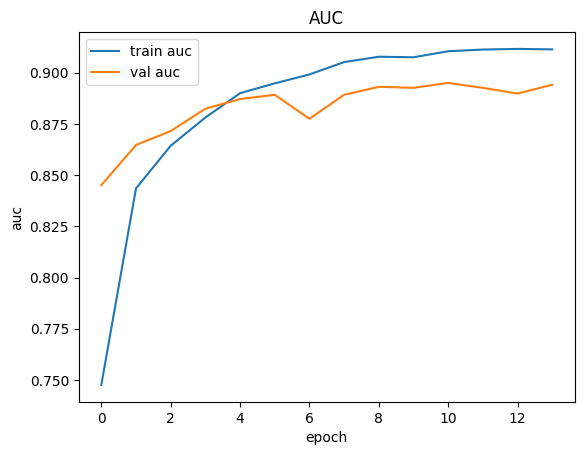

In [21]:
plot_AUC(history_B0)

In [22]:
y_true = test_df["label"].values
probs  = model_B0.predict(test_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.26      0.75      0.39        67
         bcc       0.37      0.50      0.43       113
         bkl       0.43      0.39      0.41       278
          df       0.09      0.63      0.16        19
         mel       0.36      0.39      0.37       245
          nv       0.93      0.75      0.83      1586
        vasc       0.51      0.78      0.62        64

    accuracy                           0.66      2372
   macro avg       0.42      0.60      0.46      2372
weighted avg       0.75      0.66      0.69      2372

[[  50    8    3    3    2    1    0]
 [  25   57   10    8    2    5    6]
 [  57   18  109   38   26   27    3]
 [   0    3    0   12    0    4    0]
 [  25   18   48    8   96   39   11]
 [  33   49   85   60  143 1188   28]
 [   0    0    0    3    1   10   50]]


In [23]:
# Unfreeze top layers
base_B0.trainable = True
for layer in base_B0.layers[:-30]:
    layer.trainable = False

# Re-compile with a smaller LR
model_B0.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", multi_label=True, num_labels=NUM_CLASSES, name="auc")
    ],
)


cb_B0 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=2, verbose=1),
]

In [24]:
history_B0 = model_B0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=cb_base,
    verbose=1
)


Epoch 1/30


E0000 00:00:1762562668.402000    5306 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762562668.583208    5306 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762562668.769969    5306 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


232/234 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - auc: 0.8437 - loss: 1.2825

E0000 00:00:1762562691.715728    5306 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762562691.906479    5306 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


234/234 ━━━━━━━━━━━━━━━━━━━━ 55s 139ms/step - auc: 0.8441 - loss: 1.2811 - val_auc: 0.8949 - val_loss: 1.0533 - learning_rate: 1.0000e-04
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - auc: 0.9121 - loss: 0.8959 - val_auc: 0.9115 - val_loss: 0.9456 - learning_rate: 1.0000e-04
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - auc: 0.9301 - loss: 0.7163 - val_auc: 0.9219 - val_loss: 0.8476 - learning_rate: 1.0000e-04
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - auc: 0.9429 - loss: 0.6487 - val_auc: 0.9190 - val_loss: 0.8610 - learning_rate: 1.0000e-04
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - auc: 0.9537 - loss: 0.5657 - val_auc: 0.9205 - val_loss: 0.8251 - learning_rate: 1.0000e-04
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - auc: 0.9537 - loss: 0.5256 - val_auc: 0.9313 - val_loss: 0.7572 - learning_rate: 1.0000e-04
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - auc: 0.9605 - loss: 0.4819 - val_auc: 0.9318 - val_loss: 0.7563 - 

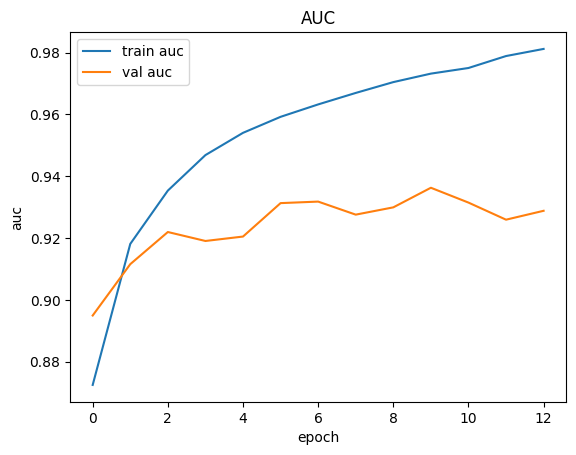

In [25]:
plot_AUC(history_B0)

In [26]:
y_true = test_df["label"].values
probs  = model_B0.predict(test_ds, verbose=0)
y_pred = probs.argmax(1)

classification_report_display(y_true, y_pred)

confusion_matrix_display(y_true, y_pred)

              precision    recall  f1-score   support

       akiec       0.47      0.67      0.56        67
         bcc       0.49      0.76      0.59       113
         bkl       0.51      0.59      0.55       278
          df       0.27      0.74      0.40        19
         mel       0.37      0.58      0.45       245
          nv       0.95      0.77      0.85      1586
        vasc       0.83      0.78      0.81        64

    accuracy                           0.72      2372
   macro avg       0.56      0.70      0.60      2372
weighted avg       0.79      0.72      0.75      2372

[[  45    8    8    0    5    1    0]
 [   6   86    7    4    7    1    2]
 [  29   17  164    8   45   15    0]
 [   1    3    0   14    0    1    0]
 [   5    6   47    4  142   40    1]
 [   9   49   95   21  190 1215    7]
 [   0    8    0    0    0    6   50]]
